In [9]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from palmerpenguins import load_penguins
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV

In [38]:
ha = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
ha

,Name,age,sex,cp,trtbps,chol,restecg,thalach,diagnosis
0,Magnolia Cassin,60,1,1,117,230,1,160,No Disease
1,Dr. Cathern Heathcote,60,0,3,102,318,1,160,Disease
2,Miles Wolf,62,0,3,130,263,1,97,No Disease
3,Mikaila Block,43,1,1,115,303,1,181,Disease
4,Mrs. Jacquline Marquardt,66,1,1,120,302,0,151,Disease
...,...,...,...,...,...,...,...,...,...
199,Bridgett Franecki,55,0,1,128,205,2,130,No Disease
200,Mr. Foster Zieme,51,1,3,94,227,1,154,Disease
201,Lashanda Hagenes,42,1,2,120,295,1,162,Disease
202,Levern Trantow III,35,0,1,138,183,1,182,Disease


In [11]:
ct = ColumnTransformer(
  [
    ("dummify", #Dummifying variables that need it
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [78]:
y = ha['diagnosis']
X = ha[['age','chol']]

In [79]:
ct2 = ColumnTransformer(
  [
    ("dummify", #Dummifying variables that need it
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'), #If we haven't trained on a column, don't use for predicting on test validation
    make_column_selector(dtype_include=object))
  ],
  remainder = "passthrough"
)

In [80]:
pipe_LR = Pipeline([
    ("preprocessing", ct2),
    ("model", LogisticRegression())
])
pipe_LR.fit(X, y)

print(pipe_LR.named_steps['model'].coef_)
print(pipe_LR.named_steps['model'].intercept_)

[[0.04686331 0.00180124]]
[-3.24011226]


In [81]:
age_beta_lr = pipe_LR.named_steps['model'].coef_[0][0]
chol_beta_lr = pipe_LR.named_steps['model'].coef_[0][1]
intercept_lr = pipe_LR.named_steps['model'].intercept_[0]

In [82]:
#Solving:  0 = -0.054 * 55 - 0.0011 * chol + 3.363
(0-intercept_lr - 55*age_beta_lr)/chol_beta_lr

367.8748897986013

In [83]:
#p_i is probability of the 1 in y column, which is disease
#zi = log(p_i / 1 - p_i)
#For .9 probability, zi = log(.9/(1-.9)) = log(.9/.1) = log(9)
z = np.log(9)
(z-intercept_lr - 55*age_beta_lr)/chol_beta_lr


1587.7158792753316

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [84]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", LinearDiscriminantAnalysis())
])
pipe.fit(X, y)

print(pipe.named_steps['model'].coef_)
print(pipe.named_steps['model'].intercept_)

age_beta_lda = pipe.named_steps['model'].coef_[0][0]
chol_beta_lda = pipe.named_steps['model'].coef_[0][1]
intercept_lda = pipe.named_steps['model'].intercept_[0]

(0-intercept_lda - 55*age_beta_lda)/chol_beta_lda

[[0.04655744 0.00178967]]
[-3.21967766]


368.23535752993814

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [85]:
from sklearn.svm import SVC

pipe = Pipeline([
    ("preprocessing", ct2),
    ("model", SVC(kernel='linear'))
])
pipe.fit(X, y)

print(pipe.named_steps['model'].coef_)
print(pipe.named_steps['model'].intercept_)

age_beta_svc = pipe.named_steps['model'].coef_[0][0]
chol_beta_svc = pipe.named_steps['model'].coef_[0][1]
intercept_svc = pipe.named_steps['model'].intercept_[0]

(0-intercept_svc - 55*age_beta_svc)/chol_beta_svc

[[0.06439772 0.00365896]]
[-4.68603406]


312.7005277830234

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

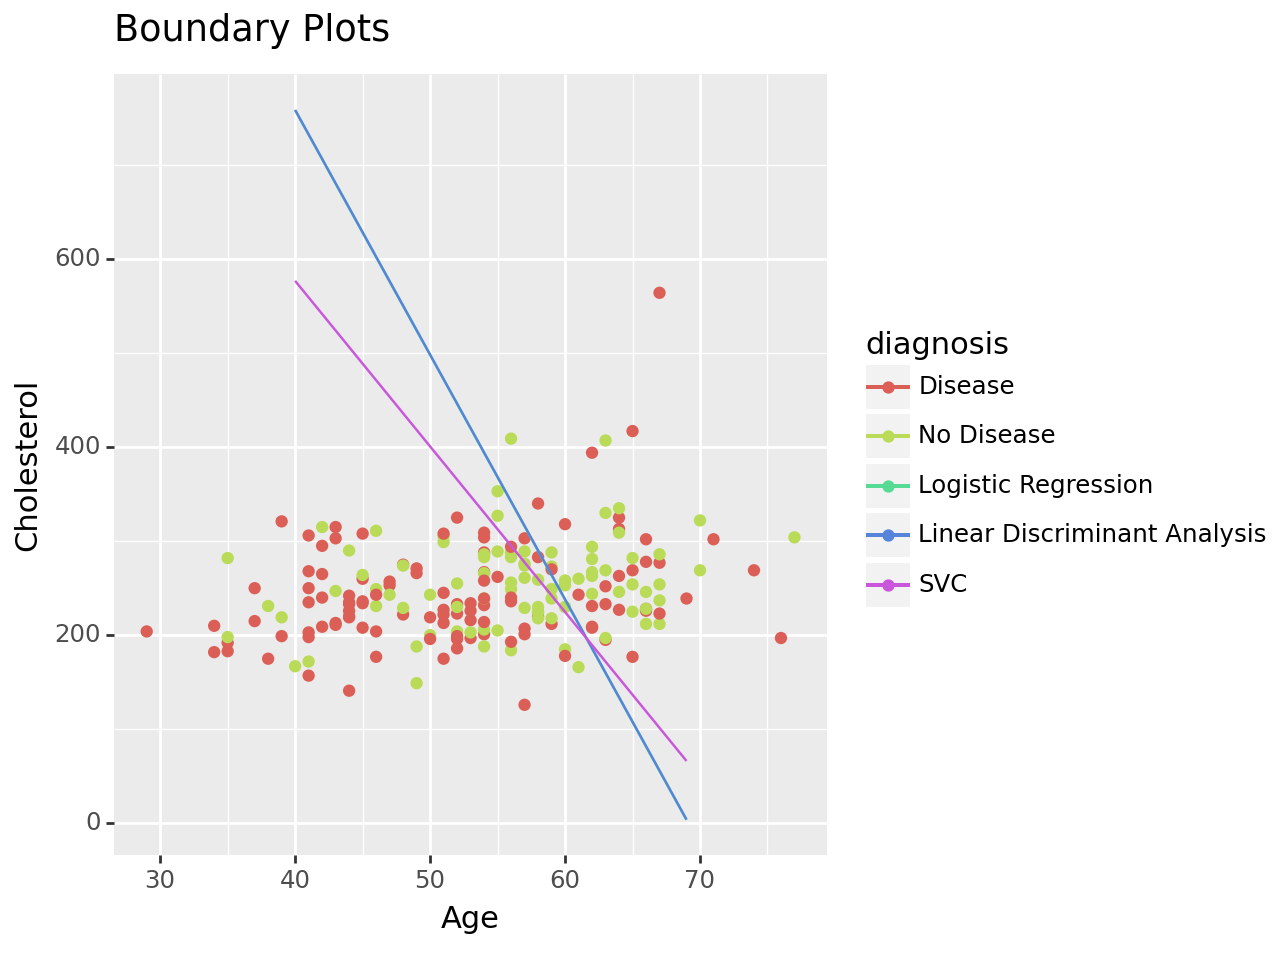

<Figure Size: (640 x 480)>

In [88]:
from plotnine import ggplot,aes,geom_point,geom_smooth,labs,geom_line,scale_color_manual

list(map(lambda x: (0-intercept - x*age_beta)/chol_beta,list(range(30,80))))
(ggplot(ha, aes(x='age', y='chol',color='diagnosis'))
    + labs(x='Age', y='Cholesterol', title='Boundary Plots')
    + geom_point()
    + geom_line(pd.DataFrame(data={'x':list(range(40,70)),'y':list(map(lambda x: (0-intercept_lr - x*age_beta_lr)/chol_beta_lr,list(range(40,70))))}),aes(x='x', y='y',color="'Logistic Regression'"))
    + geom_line(pd.DataFrame(data={'x':list(range(40,70)),'y':list(map(lambda x: (0-intercept_lda - x*age_beta_lda)/chol_beta_lda,list(range(40,70))))}),aes(x='x', y='y',color="'Linear Discriminant Analysis'"))
    + geom_line(pd.DataFrame(data={'x':list(range(40,70)),'y':list(map(lambda x: (0-intercept_svc - x*age_beta_svc)/chol_beta_svc,list(range(40,70))))}),aes(x='x', y='y',color="'SVC'"))
)